In [1]:
!nvidia-smi 

Tue Dec 10 16:49:33 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.36       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   32C    P0    25W / 250W |      0MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [0]:
!pip install -q kaggle

In [0]:
from google.colab import files

In [4]:
uploaded = files.upload()

Saving kaggle.json to kaggle.json


In [0]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/kaggle.json
!echo '{"username":"karentree","key":"ff57b9d030d708de9af1a8da9558d6df"}' > /root/.kaggle/kaggle.json
!chmod 600 /root/.kaggle/kaggle.json


In [0]:
!kaggle datasets download -d karentree/artchallenge-118-artists-classification
!unzip /content/artchallenge-118-artists-classification.zip

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
import os
from tqdm import tqdm, tqdm_notebook
import random

import tensorflow as tf
from keras.models import Sequential, Model
from keras.layers import *
from keras.optimizers import *
from keras.applications import *
from keras.callbacks import *
from keras.initializers import *
from keras.preprocessing.image import ImageDataGenerator

from numpy.random import seed
seed(1)
from tensorflow import set_random_seed
set_random_seed(1)

Using TensorFlow backend.


In [8]:
artists = pd.read_csv("artists_all.csv")
artists = artists.iloc[:,1:]
artists

,name,years,genre,nationality,paintings,number_of_genre
0,Amedeo Modigliani,1884 - 1920,['Expressionism'],['Italian'],193,1
1,Vasiliy Kandinskiy,1866 - 1944,"['Expressionism', 'Abstractionism']",['Russian'],88,2
2,Diego Rivera,1886 - 1957,"['Social Realism', 'Muralism']",['Mexican'],70,2
3,Claude Monet,1840 - 1926,['Impressionism'],['French'],73,1
4,Rene Magritte,1898 - 1967,"['Surrealism', 'Impressionism']",['Belgian'],194,2
...,...,...,...,...,...,...
113,Nikolai Ge,1831 – 1894,['Realism'],['Russian'],43,1
114,Robert Campin,1375 – 1444,['Northern Renaissance'],['Flemish'],42,1
115,Fyodor Rokotov,1736 – 1808,['Rococo'],['Russian'],32,1
116,Rockwell Kent,1882 – 1971,['Realism'],['American'],51,1


In [0]:
artists = artists[artists['paintings'] > 200]
artists = artists.reset_index()
artists['class_weight'] = artists.paintings.sum() / (artists.shape[0] * artists.paintings)
class_weights = artists['class_weight'].to_dict()

In [0]:
# Explore images of top artists
images_dir = '/content/images'
artists_dirs = os.listdir(images_dir)
artists_name = artists['name'].str.replace(' ', '_').values
# change Albrecht_Dürer to Albrecht_DuтХа├кrer
artists_name = ['Albrecht_DuтХа├кrer' if x == 'Albrecht_Dürer' else x for x in artists_name]

In [11]:
# check if image directory is valid for all artists
for name in artists_name:
    if os.path.exists(os.path.join(images_dir, name)):
        print("Found -->", os.path.join(images_dir, name))
    else:
        print("Did not find -->", os.path.join(images_dir, name))

Found --> /content/images/Vincent_van_Gogh
Found --> /content/images/Pablo_Picasso
Found --> /content/images/Pierre-Auguste_Renoir
Found --> /content/images/Francisco_Goya
Found --> /content/images/Albrecht_DuтХа├кrer
Found --> /content/images/Alfred_Sisley
Found --> /content/images/Marc_Chagall
Found --> /content/images/Edgar_Degas
Found --> /content/images/Rembrandt
Found --> /content/images/Titian
Found --> /content/images/Paul_Gauguin
Found --> /content/images/Ivan_Shishkin
Found --> /content/images/Nicholas_Roerich
Found --> /content/images/Andrew_Wyeth
Found --> /content/images/Ivan_Aivazovsky
Found --> /content/images/Zinaida_Serebriakova
Found --> /content/images/Egon_Schiele
Found --> /content/images/Alphonse_Mucha
Found --> /content/images/Edward_Burne-Jones
Found --> /content/images/Gustave_Moreau
Found --> /content/images/Paul_Signac
Found --> /content/images/Alexandre_Benois
Found --> /content/images/Aleksandr_Deyneka
Found --> /content/images/Lucas_Cranach_the_Elder
Found

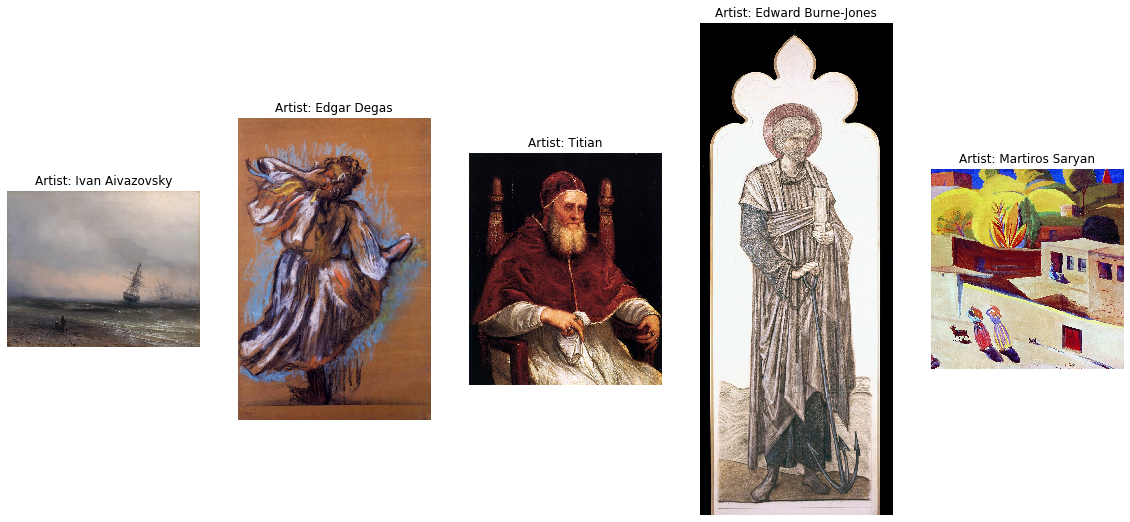

In [12]:
n = 5
fig, axes = plt.subplots(1, n, figsize=(20,10))

for i in range(n):
    random_artist = random.choice(artists_name)
    # get a random image in the 
    random_image = random.choice(os.listdir(os.path.join(images_dir, random_artist)))
    #print(random_image)
    random_image_file = os.path.join(images_dir, random_artist, random_image)
    image = plt.imread(random_image_file)
    axes[i].imshow(image)
    axes[i].set_title("Artist: " + random_artist.replace('_', ' '))
    axes[i].axis('off')
    
plt.show()

In [13]:
batch_size = 12
train_input_shape = (224, 224, 3)
n_classes = artists.shape[0]
print(n_classes)
train_datagen = ImageDataGenerator(validation_split=0.2,
                                   rescale=1./255.,
                                   #rotation_range=45,
                                   #width_shift_range=0.5,
                                   #height_shift_range=0.5,
                                   shear_range=5,
                                   #zoom_range=0.7,
                                   horizontal_flip=True,
                                   vertical_flip=True,
                                  )
train_generator = train_datagen.flow_from_directory(directory=images_dir,
                                                    class_mode='categorical', # 118 class
                                                    target_size=train_input_shape[0:2],
                                                    batch_size=batch_size,
                                                    subset="training",
                                                    shuffle=True,
                                                    classes=artists_name
                                                   )

valid_generator = train_datagen.flow_from_directory(directory=images_dir,
                                                    class_mode='categorical',
                                                    target_size=train_input_shape[0:2],
                                                    batch_size=batch_size,
                                                    subset="validation",
                                                    shuffle=True,
                                                    classes=artists_name
                                                   )

STEP_SIZE_TRAIN = train_generator.n//train_generator.batch_size
STEP_SIZE_VALID = valid_generator.n//valid_generator.batch_size
print("Total number of batches =", STEP_SIZE_TRAIN, "and", STEP_SIZE_VALID)

25
Found 7144 images belonging to 25 classes.
Found 1772 images belonging to 25 classes.
Total number of batches = 595 and 147


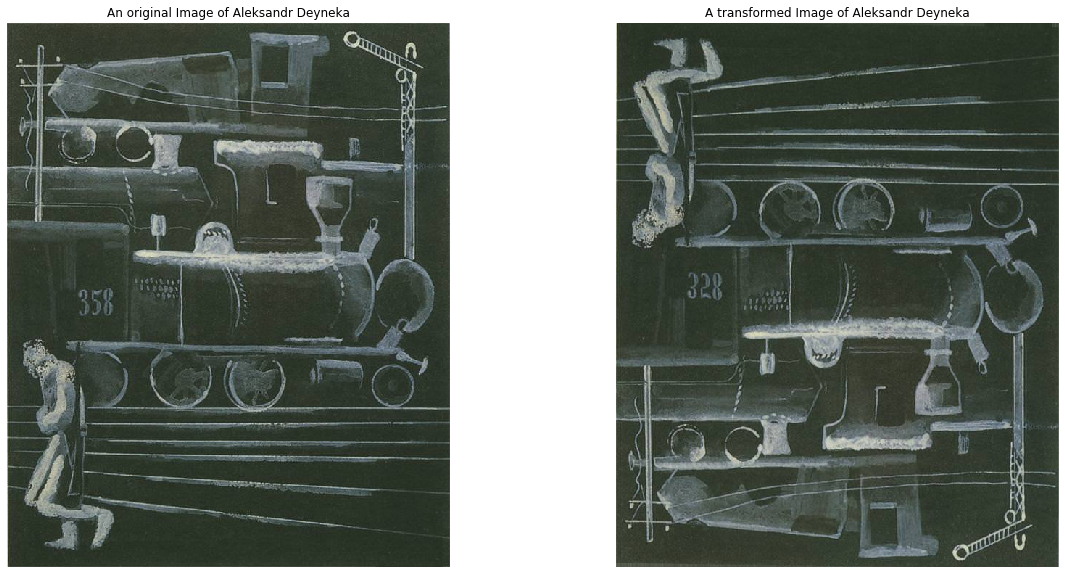

In [14]:
fig, axes = plt.subplots(1, 2, figsize=(20,10))

random_artist = random.choice(artists_name)
random_image = random.choice(os.listdir(os.path.join(images_dir, random_artist)))
random_image_file = os.path.join(images_dir, random_artist, random_image)

# Original image
image = plt.imread(random_image_file)
axes[0].imshow(image)
axes[0].set_title("An original Image of " + random_artist.replace('_', ' '))
axes[0].axis('off')

# Transformed image
aug_image = train_datagen.random_transform(image)
axes[1].imshow(aug_image)
axes[1].set_title("A transformed Image of " + random_artist.replace('_', ' '))
axes[1].axis('off')

plt.show()

In [0]:
n_class=artists.shape[0]

def alexnet_model(img_shape=(224, 224, 3), n_classes=n_class, l2_reg=0.,
	weights=None):

	# Initialize model
	alexnet = Sequential()

	# Layer 1
	alexnet.add(Conv2D(filters=96, kernel_size=(11,11), strides=(4,4), input_shape=img_shape,
						padding='valid'))
	alexnet.add(Activation('relu'))
	alexnet.add(MaxPooling2D(pool_size=(3, 3),strides=(2,2)))
	# Batch Normalization before passing it to the next layer
	alexnet.add(BatchNormalization())

	# Layer 2
	alexnet.add(Conv2D(256, (5, 5), padding='same'))
	alexnet.add(Activation('relu'))
	alexnet.add(MaxPooling2D(pool_size=(3, 3),strides=(2,2)))
	alexnet.add(BatchNormalization())

	# Layer 3
	alexnet.add(Conv2D(384, (3, 3), padding='same',strides=(1,1)))
	alexnet.add(Activation('relu'))
	#alexnet.add(MaxPooling2D(pool_size=(2, 2)))
	alexnet.add(BatchNormalization())

	# Layer 4
	alexnet.add(Conv2D(384, (3, 3), padding='same',strides=(1,1)))
	alexnet.add(BatchNormalization())
	alexnet.add(Activation('relu'))
	alexnet.add(BatchNormalization())

	# Layer 5
	alexnet.add(Conv2D(256, (3, 3), padding='same',strides=(1,1)))
	alexnet.add(BatchNormalization())
	alexnet.add(Activation('relu'))
	alexnet.add(MaxPooling2D(pool_size=(3, 3), strides=(2,2)))
	alexnet.add(BatchNormalization())

	# Layer 6
	alexnet.add(Flatten())
	alexnet.add(Dense(3072))
	#alexnet.add(BatchNormalization())
	alexnet.add(Activation('relu'))
	alexnet.add(Dropout(0.5))


	# Layer 7
	alexnet.add(Dense(3072))
	#alexnet.add(BatchNormalization())
	alexnet.add(Activation('relu'))
	alexnet.add(Dropout(0.5))

	# Layer 8
	alexnet.add(Dense(n_classes))
	alexnet.add(BatchNormalization())
	alexnet.add(Activation('softmax'))	

	return alexnet


In [16]:
model = alexnet_model()













Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [17]:
model.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['accuracy'])

In [0]:
early_stop = EarlyStopping(monitor='val_loss', patience=20, verbose=1, 
                           mode='auto', restore_best_weights=True)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, 
                              verbose=1, mode='auto')

In [30]:
n_epoch = 20

from keras.callbacks import CSVLogger
csv_logger = CSVLogger("Alexnet_history_artist_log_50.csv", append=True)
history1 = model.fit_generator(generator=train_generator, steps_per_epoch=STEP_SIZE_TRAIN,
                              validation_data=valid_generator, validation_steps=STEP_SIZE_VALID,
                              epochs=n_epoch,
                              shuffle=True,
                              verbose=1,
                              callbacks=[reduce_lr,csv_logger],
                              use_multiprocessing=True,
                              workers=16
                             )

Epoch 1/20
595/595 [==============================] - 198s 333ms/step - loss: 0.8371 - acc: 0.7662 - val_loss: 1.3443 - val_acc: 0.6327
Epoch 2/20
595/595 [==============================] - 199s 334ms/step - loss: 0.8229 - acc: 0.7714 - val_loss: 1.4064 - val_acc: 0.6182
Epoch 3/20
595/595 [==============================] - 198s 333ms/step - loss: 0.8153 - acc: 0.7725 - val_loss: 1.3449 - val_acc: 0.6432
Epoch 4/20
595/595 [==============================] - 198s 333ms/step - loss: 0.8224 - acc: 0.7717 - val_loss: 1.3697 - val_acc: 0.6324
Epoch 5/20
595/595 [==============================] - 198s 333ms/step - loss: 0.7962 - acc: 0.7772 - val_loss: 1.3552 - val_acc: 0.6335
Epoch 6/20
595/595 [==============================] - 198s 333ms/step - loss: 0.7882 - acc: 0.7845 - val_loss: 1.3815 - val_acc: 0.6278

Epoch 00006: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
Epoch 7/20
595/595 [==============================] - 198s 332ms/step - loss: 0.7817 - acc: 0.7836 - v

In [22]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
from keras.models import load_model
# save model weight to google drive
path = "/content/gdrive/My Drive/Alexnet_model_artists_200.h5" 
model.save(path)

In [0]:
# Classification report and confusion matrix
from sklearn.metrics import *
import seaborn as sns

tick_labels = artists['name'].to_list()

def showClassficationReport_Generator(model, valid_generator, STEP_SIZE_VALID):
    # Loop on each generator batch and predict
    y_pred, y_true = [], []
    for i in range(STEP_SIZE_VALID):
        (X,y) = next(valid_generator)
        y_pred.append(model.predict(X))
        y_true.append(y)
    
    # Create a flat list for y_true and y_pred
    y_pred = [subresult for result in y_pred for subresult in result]
    y_true = [subresult for result in y_true for subresult in result]
    
    # Update Truth vector based on argmax
    y_true = np.argmax(y_true, axis=1)
    y_true = np.asarray(y_true).ravel()
    
    # Update Prediction vector based on argmax
    y_pred = np.argmax(y_pred, axis=1)
    y_pred = np.asarray(y_pred).ravel()
    
    # Confusion Matrix
    fig, ax = plt.subplots(figsize=(10,10))
    conf_matrix = confusion_matrix(y_true, y_pred, labels=np.arange(n_class))
    conf_matrix = conf_matrix/np.sum(conf_matrix, axis=1)
    sns.heatmap(conf_matrix, annot=True, fmt=".2f", square=True, cbar=False, 
                cmap=plt.cm.jet, xticklabels=tick_labels, yticklabels=tick_labels,
                ax=ax)
    ax.set_ylabel('Actual')
    ax.set_xlabel('Predicted')
    ax.set_title('Confusion Matrix')
    bottom, top = ax.get_ylim()
    ax.set_ylim(bottom + 0.5, top - 0.5)
    plt.show()
    
    print('Classification Report:')
    print(classification_report(y_true, y_pred, labels=np.arange(n_class), target_names=artists['name'].to_list()))



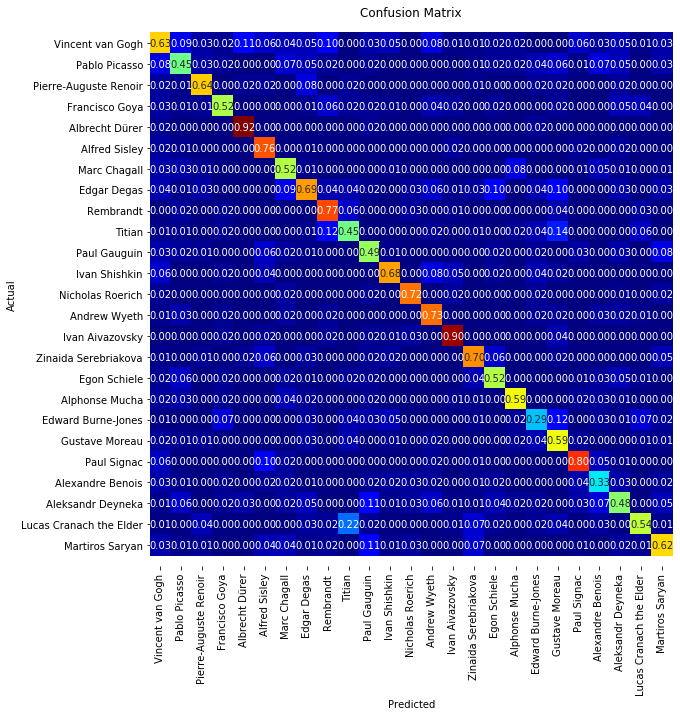

Classification Report:
                         precision    recall  f1-score   support

       Vincent van Gogh       0.51      0.63      0.56       174
          Pablo Picasso       0.50      0.45      0.47        87
  Pierre-Auguste Renoir       0.74      0.64      0.69        67
         Francisco Goya       0.67      0.52      0.58        58
         Albrecht Dürer       0.85      0.92      0.88        65
          Alfred Sisley       0.64      0.76      0.70        50
           Marc Chagall       0.55      0.52      0.53        46
            Edgar Degas       0.60      0.69      0.64       140
              Rembrandt       0.66      0.77      0.71        52
                 Titian       0.50      0.45      0.47        51
           Paul Gauguin       0.51      0.49      0.50        61
          Ivan Shishkin       0.74      0.68      0.71        81
       Nicholas Roerich       0.83      0.72      0.77        40
           Andrew Wyeth       0.66      0.73      0.69        52
 

In [25]:
showClassficationReport_Generator(model, valid_generator, STEP_SIZE_VALID)

Text(0, 0.5, 'accuracy')

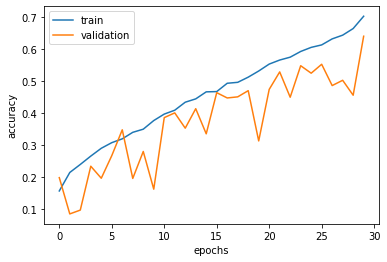

In [26]:
import matplotlib.pyplot as plt

plt.plot(history1.history['acc'], label='train')
plt.plot(history1.history['val_acc'], label='validation')
plt.legend()
plt.xlabel('epochs')
plt.ylabel('accuracy')